In [1]:
!pip install replay-rec --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that

In [2]:
!pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 19.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import os
from replay.metrics import HitRate, NDCG, MAP, Experiment
import implicit
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import scipy.sparse as sparse
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
USER_COL = 'userId'
ITEM_COL = 'movieId'
RATING_COL = 'rating'
TIMESTAMP = 'timestamp'
GENRE_COL = 'genres'

# EDA

In [5]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2024-06-27 17:49:59--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  2.99MB/s    in 0.3s    

2024-06-27 17:49:59 (2.99 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [6]:
ratings = pd.read_csv('./ml-latest-small/ratings.csv', parse_dates=['timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
print(f'Уникальных юзеров: {ratings[USER_COL]. nunique()}')
print(f'Уникальных фильмов: {ratings[ITEM_COL].nunique()}')

Уникальных юзеров: 610
Уникальных фильмов: 9724


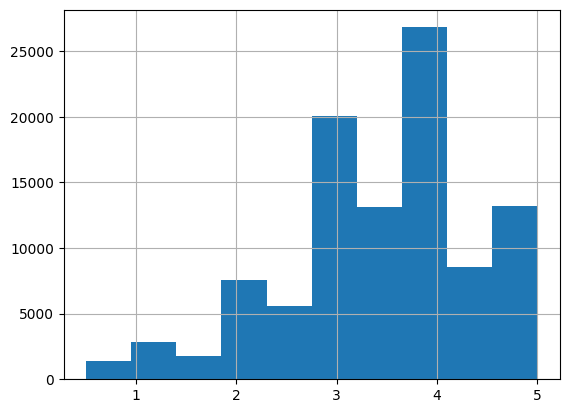

In [8]:
ratings[RATING_COL].hist();

In [9]:
movies = pd.read_csv('./ml-latest-small/movies.csv')
movies[GENRE_COL] = movies.pop(GENRE_COL).str.split('|')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


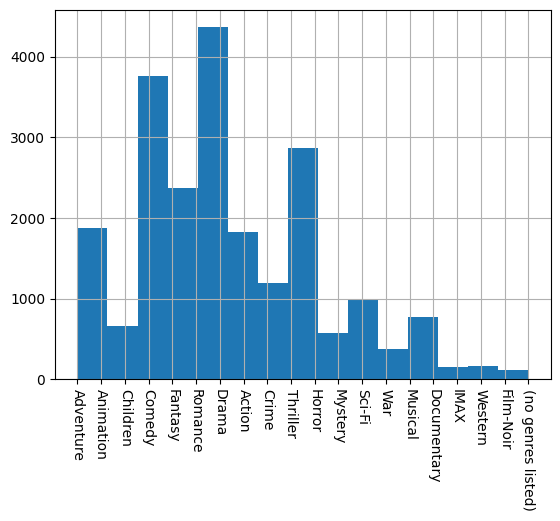

In [10]:
movies.explode(GENRE_COL)[GENRE_COL].hist(xrot=-90, bins=15);

In [11]:
ratings = ratings.merge(movies, on=ITEM_COL)

In [12]:
item_counts = ratings.groupby(ITEM_COL)[USER_COL].count()
pop_items = item_counts[item_counts > 20]
ratings = ratings[ratings[ITEM_COL].isin(pop_items.index)]

## train-test split

In [13]:
all_users = ratings[USER_COL].unique().tolist()
all_items = ratings[ITEM_COL].unique().tolist()

n_users = ratings[USER_COL].nunique()
n_items = ratings[ITEM_COL].nunique()

user_id2idx = dict(zip(all_users, range(n_users)))
item_id2idx = dict(zip(all_items, range(n_items)))

ratings[USER_COL] = ratings[USER_COL].map(user_id2idx)
ratings[ITEM_COL] = ratings[ITEM_COL].map(item_id2idx)

In [14]:
full_history = ratings.sort_values([USER_COL, TIMESTAMP]).groupby(USER_COL)
test = full_history.tail(1)
train = full_history.head(-1)

train.shape, test.shape

((66048, 6), (610, 6))

In [15]:
train = train.reset_index()
test = test.reset_index()

In [16]:
test = test[test[RATING_COL] == 5]

# Models

In [17]:
class BaseFactorizationModel:
    def __init__(self, random_state=0, user_col=USER_COL, item_col=ITEM_COL, rating_col=RATING_COL):
        self.random_state = np.random.RandomState(random_state)
        self.user_col = user_col
        self.item_col = item_col
        self.rating_col = rating_col
        self.user_matrix = None
        self.item_matrix = None


    def get_rating_matrix(self, data):
        return pd.pivot_table(
            data,
            values=self.rating_col,
            index=self.user_col,
            columns=self.item_col,
            fill_value=0
            ).values


    def predict(self, scores, rating_matrix=None, filter_seen=True, k=10):
        if filter_seen:
            scores = np.multiply(scores,
            np.invert(rating_matrix.astype(bool))
            )

        ind_part = np.argpartition(scores, -k + 1)[:, -k:].copy()
        scores_not_sorted = np.take_along_axis(scores, ind_part, axis=1)
        ind_sorted = np.argsort(scores_not_sorted, axis=1)
        scores_sorted = np.sort(scores_not_sorted, axis=1)
        indices = np.take_along_axis(ind_part, ind_sorted, axis=1)

        preds = pd.DataFrame({
            self.user_col: range(scores.shape[0]),
            self.item_col: np.flip(indices, axis=1).tolist(),
            self.rating_col: np.flip(scores_sorted, axis=1).tolist()
            }).explode([self.item_col, self.rating_col])

        return preds

# SVD

In [18]:
class SVD(BaseFactorizationModel):
    def __init__(self, random_state=0, user_col=USER_COL, item_col=ITEM_COL, n_factors=20):
        super().__init__(random_state, user_col, item_col)
        self.n_factors = n_factors


    def fit(self, data):
        self.rating_matrix = self.get_rating_matrix(data)
        csr_rating_matrix = csr_matrix(self.rating_matrix.astype(float))
        user_matrix, singular_values, item_matrix = svds(A=csr_rating_matrix, k=self.n_factors)
        user_matrix = user_matrix * np.sqrt(singular_values)
        item_matrix = item_matrix.T * np.sqrt(singular_values)

        self.user_matrix = user_matrix
        self.item_matrix = item_matrix
        self.scores = user_matrix @ item_matrix.T


In [19]:
svd_model = SVD()
svd_model.fit(train)

In [20]:
preds_svd = svd_model.predict(svd_model.scores, svd_model.rating_matrix)

In [22]:
K = [10]
metrics = Experiment(
    [
        NDCG(K),
        MAP(K),
        HitRate(K),
    ],
    test,
    query_column=USER_COL, item_column=ITEM_COL
)

In [23]:
metrics.add_result("SVD", preds_svd)
metrics.results

/usr/local/lib/python3.10/dist-packages/replay/metrics/offline_metrics.py:375: UserWarning: ground_truth contains queries that are not presented in recommendations
  warnings.warn(f"{dataset_name} contains queries that are not presented in recommendations")


,NDCG@10,MAP@10,HitRate@10
SVD,0.05491,0.032295,0.128205


# FunkSVD

In [24]:
class FunkSVD(BaseFactorizationModel):
    def __init__(self, random_state = 0, user_col=USER_COL, item_col=ITEM_COL, rating_col=RATING_COL, lr = 0.01, reg = 0.05, n_factors=20, n_epochs=5):
        super().__init__(random_state, user_col, item_col, rating_col)
        self.lr = lr
        self.reg = reg
        self.n_factors = n_factors
        self.n_epochs = n_epochs


    def fit(self, data):
        self.rating_matrix = self.get_rating_matrix(data)
        n_users, n_items = self.rating_matrix.shape

        # Parameters initialization
        mu = data[self.rating_col].mean()
        bu = np.zeros(n_users)
        bi = np.zeros(n_items)
        P = self.random_state.normal(size=(n_users, self.n_factors))
        Q = self.random_state.normal(size=(n_items, self.n_factors))

        for _ in tqdm(range(self.n_epochs)):
            errs = []
            for _, row in data.iterrows():
                # Get ids and ratings
                user_id = row[self.user_col]
                item_id = row[self.item_col]
                rating = row[self.rating_col]

                # Predict current rating
                pred = mu + bu[user_id] + bi[item_id] + Q[item_id] @ P[user_id]
                err = rating - pred
                errs.append(abs(err))

                # Update biases
                bu[user_id] += self.lr * (err - self.reg * bu[user_id])
                bi[item_id] += self.lr * (err - self.reg * bi[item_id])

                # Update latent factors
                P[user_id] += self.lr * (err * Q[item_id] - self.reg * P[user_id])
                Q[item_id] += self.lr * (err * P[user_id] - self.reg * Q[item_id])

            print(round(np.mean(errs), 4))
        self.user_matrix = P
        self.item_matrix = Q
        self.user_bias = bu
        self.item_bias = bi
        self.mu = mu
        self.scores = mu + bu.reshape(-1, 1) + bi + P @ Q.T

In [25]:
funk_model = FunkSVD()
funk_model.fit(train)

 20%|██        | 1/5 [00:05<00:22,  5.71s/it]

1.7702


 40%|████      | 2/5 [00:12<00:18,  6.33s/it]

0.8567


 60%|██████    | 3/5 [00:24<00:17,  8.81s/it]

0.7293


 80%|████████  | 4/5 [00:29<00:07,  7.51s/it]

0.6731


100%|██████████| 5/5 [00:39<00:00,  7.94s/it]

0.6412


In [26]:
preds_funk = funk_model.predict(funk_model.scores, funk_model.rating_matrix)

In [27]:
metrics.add_result("FunkSVD", preds_funk)
metrics.results

/usr/local/lib/python3.10/dist-packages/replay/metrics/offline_metrics.py:375: UserWarning: ground_truth contains queries that are not presented in recommendations
  warnings.warn(f"{dataset_name} contains queries that are not presented in recommendations")


,NDCG@10,MAP@10,HitRate@10
SVD,0.054910,0.032295,0.128205
FunkSVD,0.006846,0.003799,0.017094


In [28]:
k = funk_model.scores.shape[1]

In [29]:
preds_funk = funk_model.predict(funk_model.scores, funk_model.rating_matrix, k=k)
test_pred = test.merge(preds_funk, on=[USER_COL, ITEM_COL])

In [30]:
mean_absolute_error(test_pred['rating_x'], test_pred['rating_y'])

1.534745076129868

# iALS

In [31]:
base_model = BaseFactorizationModel()
rating_matrix = base_model.get_rating_matrix(train)
train_sparse = sparse.csr_matrix(rating_matrix)

In [32]:
train_sparse

<610x1235 sparse matrix of type '<class 'numpy.float64'>'
	with 66048 stored elements in Compressed Sparse Row format>

In [33]:
ials_model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50, use_gpu=False)
ials_model.fit((train_sparse).astype('double'))

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b1b3016fb50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so: cannot open shared object file: No such file or directory
/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: Runtime

  0%|          | 0/50 [00:00<?, ?it/s]

Вектора для юзеров:
```
user_vecs = ials_model.user_factors
```

Вектора для объектов:
```
item_vecs = ials_model.item_factors
```




In [34]:
user_vecs = ials_model.user_factors
item_vecs = ials_model.item_factors
# проверим по размерам, что мы действиельно не перепутали users и items
print(train_sparse.shape)
print(user_vecs.shape, item_vecs.shape)

(610, 1235)
(610, 20) (1235, 20)


In [35]:
scores = user_vecs.dot(item_vecs.T)
scores.shape

(610, 1235)

In [40]:
user_vecs[0]

array([ 1.0453504 ,  0.39633408,  0.52836394,  0.76806587, -0.04220667,
        0.09425853, -0.13775451, -0.4903366 ,  1.8147914 ,  0.6716923 ,
        1.8667012 ,  1.642703  ,  0.5851466 ,  1.7339227 , -0.52730894,
       -0.13906483,  0.9976202 ,  2.1531982 ,  0.22928154,  3.4932191 ],
      dtype=float32)

In [42]:
item_vecs[0]

array([ 2.6888117e-02,  9.3722261e-02, -1.2050441e-01,  1.9000894e-01,
        1.0748571e-01,  1.1597717e-01,  6.3356139e-02,  1.6084041e-04,
        1.0099474e-02, -2.6355937e-02,  3.5829477e-02,  1.3072616e-01,
        2.1892024e-02, -1.1459998e-01, -1.8039593e-01, -3.0765539e-02,
        1.3536951e-01, -4.1491870e-02, -2.9643413e-01,  1.2749209e-01],
      dtype=float32)

In [41]:
user_vecs[0,:].dot(item_vecs[0,:])

0.76396674

In [38]:
preds_ials = base_model.predict(scores, rating_matrix)

In [39]:
metrics.add_result("iALS", preds_ials)
metrics.results

/usr/local/lib/python3.10/dist-packages/replay/metrics/offline_metrics.py:375: UserWarning: ground_truth contains queries that are not presented in recommendations
  warnings.warn(f"{dataset_name} contains queries that are not presented in recommendations")


,NDCG@10,MAP@10,HitRate@10
SVD,0.054910,0.032295,0.128205
FunkSVD,0.006846,0.003799,0.017094
iALS,0.060669,0.045513,0.111111
